# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

*   Change the path of the directories according to your drive location.

In [2]:
import os

root_path = r'/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB10/TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

rand_imgs = os.path.join(root_path, 'foodDataset')

*   Define the constants needed for training the model

In [3]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [4]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".PNG")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


rand_img_paths = sorted(
    [
        os.path.join(rand_imgs, fname)
        for fname in os.listdir(rand_imgs)
        if fname.endswith(".jpg") and not fname.startswith(".JPG")
    ]
)


print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

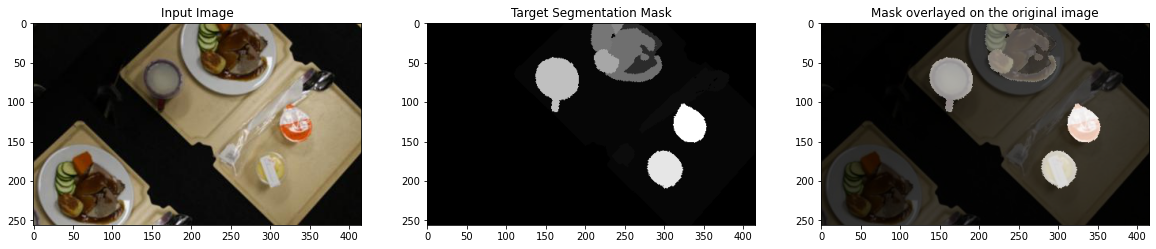

In [5]:
# solution
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from PIL.ImageOps import autocontrast

figure, axes = plt.subplots(1,3, figsize=(20,10))

axes[0].imshow(load_img(train_img_paths[9]))
axes[0].set_title('Input Image')

# Display auto-contrast version of corresponding target (per-pixel categories)
axes[1].imshow(autocontrast(load_img(train_mask_paths[9])))
axes[1].set_title('Target Segmentation Mask')

axes[2].imshow(autocontrast(load_img(train_mask_paths[9])))
axes[2].imshow(load_img(train_img_paths[9]), alpha=0.3)
axes[2].set_title('Mask overlayed on the original image')

plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [6]:
# solution

from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class ImageGeneator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y


# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [7]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [8]:
# Free up RAM in case the model definition cells were run multiple times
import keras
keras.backend.clear_session()

In [9]:
# Build model
model = get_model(img_size, num_classes)

*   Print the summary of the model

In [10]:
# solution
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [11]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGeneator(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = ImageGeneator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [12]:
# solution
Loss = "sparse_categorical_crossentropy"
model.compile(optimizer="rmsprop", loss=Loss, metrics =['accuracy',Loss])

*   Instantiate a ModelCheckpoint callback to save only the best model

In [13]:
# solution
path = '/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB10'
callbacks = [
    keras.callbacks.ModelCheckpoint(path + "/Food_segmentation.h5", save_best_only=True,monitor=Loss,mode='auto')
]

In [14]:
#If you want to load the model unless to train again 
#To load the model 
from keras.models import load_model
reconstructed_model = load_model(path+'/Edison_UNet')

*   Train the model using fit method

In [14]:
# solution
Train_History = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 1.7930 - accuracy: 0.5310 - sparse_categorical_crossentropy: 1.7930 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 407s 10s/step - loss: 1.7930 - accuracy: 0.5310 - sparse_categorical_crossentropy: 1.7930
Epoch 2/25
38/38 [==============================] - 20s 507ms/step - loss: 0.6742 - accuracy: 0.5466 - sparse_categorical_crossentropy: 0.6742
Epoch 3/25
38/38 [==============================] - 19s 503ms/step - loss: 0.4276 - accuracy: 0.5471 - sparse_categorical_crossentropy: 0.4276
Epoch 4/25
38/38 [==============================] - 20s 512ms/step - loss: 0.3467 - accuracy: 0.5460 - sparse_categorical_crossentropy: 0.3467
Epoch 5/25
38/38 [==============================] - 20s 514ms/step - loss: 0.2985 - accuracy: 0.5460 - sparse_categorical_crossentropy: 0.2985
Epoch 6/25
38/38 [==============================] - 22s 577ms/step - loss: 0.2296 - accuracy: 0.5457 - sparse_categorical_crossentropy: 0.2296
Epoch 7/25
38/38 [==============================] - 20s 507ms/step - loss: 0.2141 - accuracy: 0.5456 - sparse_categorical_crossentropy: 0.2141
Epoch 8/25


In [15]:
#save the model 
from keras.models import save_model
model.save(path+'/Edison_UNet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB10/Edison_UNet/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Visualize predictions

*   Generate predictions for all images in the validation set

In [16]:
batch_size = 1  # we define batch_size as 1 for inferencing
val_gen = ImageGeneator(batch_size, img_size, test_img_paths, test_mask_paths)

In [17]:
# solution
val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [18]:
from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize
# solution
i = 6
img1 = imread(test_img_paths[i])
img1 = resize(img1,(160,160))

*   Read the test mask images to create the ground truth

In [19]:
# solution
img2 = autocontrast(load_img(test_mask_paths[i]))
img2 = resize(np.array(img2),(160,160))
img3 = np.argmax(val_preds[i], axis=-1)

*   For each validation image, find the jaccard similarity score

In [20]:
# solution
from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score

g_t = img_as_int(resize(imread(test_mask_paths[i], as_gray=True), img_size))

*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

*
Jaccard is the metric where you define your values as the average and then compare it to a set of predicted labels for a sample with the corresponding set of labels in y_true.

1. The 'average' is a perameter metric where, summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.With this, measure the distance between the model and the data. 
2. None,micro, macro, weighted, samples.
3. This implementation is restricted to the binary classification task or multilabel classification task

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

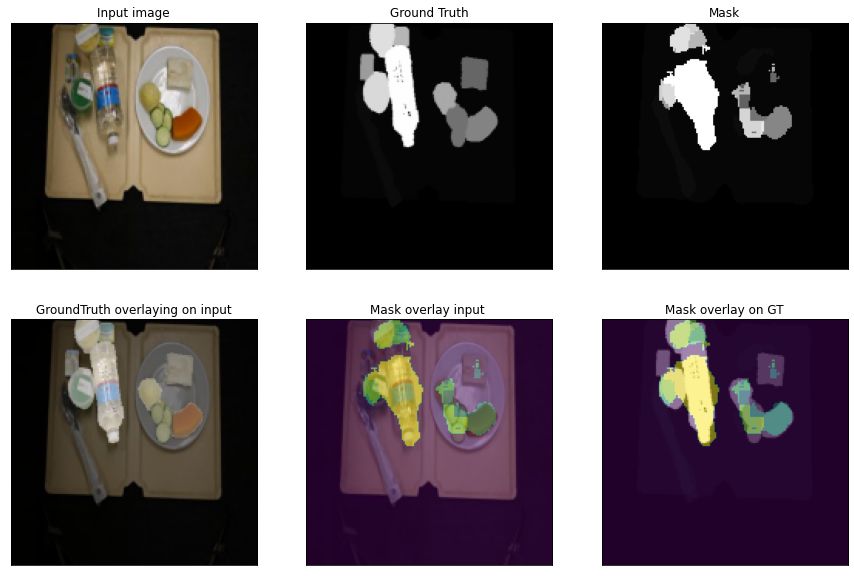

The jaccard score is:
0.3349324711894457


In [21]:
# solution
figure, axs = plt.subplots(2,3, figsize=(15,10))

axs[0][0].imshow(img1)
axs[0][0].set_title('Input image')
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])

axs[0][1].imshow(img2)
axs[0][1].set_title('Ground Truth')
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])

axs[0][2].imshow(img3, cmap="gray")
axs[0][2].set_title('Mask')
axs[0][2].set_xticks([])
axs[0][2].set_yticks([])


background = imread(test_img_paths[i])
background = resize(background, (160, 160))

axs[1][0].imshow(background)
axs[1][0].imshow(img2, alpha=0.5)
axs[1][0].set_title('GroundTruth overlaying on input')
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])

background = imread(test_img_paths[i])
background = resize(background, (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][1].imshow(background)
axs[1][1].imshow(mask, alpha=0.5)
axs[1][1].set_title('Mask overlay input ')
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])

background = autocontrast(load_img(test_mask_paths[i]))
background = resize(np.array(background), (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][2].imshow(background)
axs[1][2].imshow(mask, alpha=0.5)
axs[1][2].set_title('Mask overlay on GT')
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])

plt.show()
print('The jaccard score is:')
print(jaccard_score(g_t.flatten(), mask.flatten(), average='micro'))

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**
- accuracy_score
- f1_score
- For binary (two classes) or multi-class segmentation

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [22]:
# solution

internet_img = r'/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB10/TrayDataset/foodDataset'

testing_img_model = os.path.join(internet_img)

testing_img_model = sorted(
    [
        os.path.join(internet_img, fname)
        for fname in os.listdir(internet_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)
print("Number of testing samples for the model:", len(testing_img_model))

Number of testing samples for the model: 10


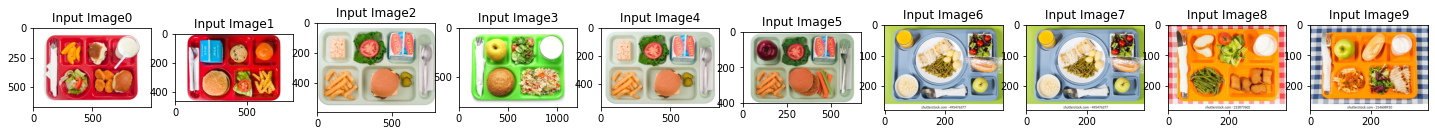

In [23]:
#We going to visualize all the sample images

figure, axes = plt.subplots(1,len(testing_img_model), figsize=(25,5))
for i in range(len(testing_img_model)):
  axes[i].imshow(load_img(testing_img_model[i]))
  axes[i].set_title(f'Input Image{i}')

plt.show()

In [24]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class ImageGenTesting(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x

In [25]:
# solution
keras.backend.clear_session()
img_path = '/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB10/TrayDataset/foodDataset'
batch_size = 1  # we define batch_size as 1 for inferencing
rand_pred = ImageGenTesting(batch_size, img_size, rand_img_paths)

In [26]:
rand_pred = model.predict(rand_pred)

In [27]:
# solution
i = 2
#Original image
img_original = imread(rand_img_paths[i])
img_original = resize(img_original,(160,160))

img_random_prediction = np.argmax(rand_pred[i], axis=-1)

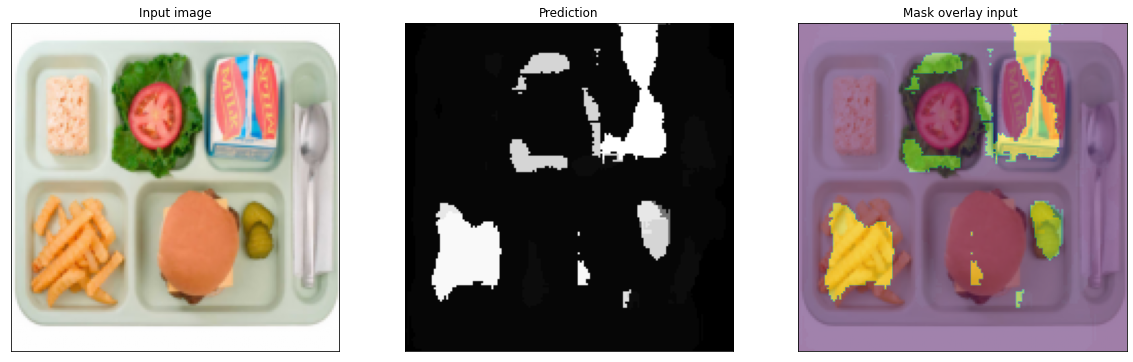

In [28]:
figure, axs = plt.subplots(1,3, figsize=(20,10))

axs[0].imshow(img_original)
axs[0].set_title('Input image')
axs[0].set_xticks([])
axs[0].set_yticks([])


axs[1].imshow(img_random_prediction, cmap="gray")
axs[1].set_title('Prediction')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(img_random_prediction)
axs[2].imshow(img_original, alpha=0.5)

axs[2].set_title('Mask overlay input ')
axs[2].set_xticks([])
axs[2].set_yticks([])



plt.show()



*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

*As expected, when making predictions with images that are very different from that of the dataset, it is normal for the precision to be low, since many of the elements cannot be recognized.*

*Two things happen with unlabeled classes. The first is that it is not recognized and therefore our model does not detect it or the second situation is that our model assimilates it with something that is similar to the images with which it was trained.*

...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

*
1. Some of the challenges when we use a trained model in the wild are:
  - The images must be similars to obtain good results
  - In many cases is difficult that the images can be similars than the train set
  - We can find that the same label can be obverse in other way, with that the accuracy can be affected
  - It is neccesary feedback to improve our model and adapted to the real world

2. It is neccesary to have a good dataset to train our model with many examples that can find our model in the real world, with that can be offered a good quality. Also, it is good if we can apply feedback. The main thing to develop the model is identify the pourpuse, how can we solve the problem, with semantic or instance segmentation?, we need to detect in real time?. With all of this in mind, we can start to choose our better framework, and with our dataset preset, we can train our model, it is neccesary a generous quantity of samples to obtain goods results.

*

...

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

- Semantic segmentation. Objects shown in an image are grouped based on defined categories.
- Instance segmentation. Consider instance segmentation a refined version of semantic segmentation. Categories like “vehicles” are split into “cars,” “motorcycles,” “buses,” and so on — instance segmentation detects the instances of each category.

...

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

An Encoder-Decoder architecture was developed where an input sequence was read in entirety and encoded to a fixed-length internal representation.

A decoder network then used this internal representation to output words until the end of sequence token was reached. 

...

*   What is upsampling?

**Solution**

Upsampling is increasing height and width of the feature map. The upsampling have two types of layers used:
  1. SImple scaling - upSampling2D
  2. Transposed Convolution(Deconvolution) - COnv2DTranspose


*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

*The feature channels simply mean the number of channels at a given point in the network. In the U-Net architecture, the number of channels doubles after the max pooling layers, see for example the first max pooling layer. The input is of size 568 by 568 pixels with 64 (feature) channels, after max pooling this becomes an array of size 284 by 284 pixels with the same 64 channels. The next convolutional layer then keeps the same size, so 284 by 284 pixels, but doubles the number of channels to 128.*

...

*   What are some applications of U-Net?

**Solution**

Some applications for the U-Net are:

1. Pixel-wise regression using U-Net and its application on pansharpening
2. 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
3. TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation
4. Image-to-image translation to estimate fluorescent stains




---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Monday, the 3rd of January, 2022**